### Load Data

In [25]:
import os
import numpy as np
import pandas as pd
from PIL import Image

csv_path, csv_test_path = "./data/train.csv", "./data/test.csv"
img_dir, img_dir_test = "./data/train_ims", "./data/test_ims"

data_train = pd.read_csv(csv_path)
print(data_train)
data_test = pd.read_csv(csv_test_path)

X_train, y_train, X_test, y_test = [], [], [], []

for _, row in data_train.iterrows():
    img_path = os.path.join(img_dir, row.iloc[0])
    label = int(row.iloc[1])
    img = Image.open(img_path).convert("RGB")
    img = np.array(img).flatten()
    X_train.append(img)
    y_train.append(label)

for _, row in data_test.iterrows():
    img_path = os.path.join(img_dir_test, row.iloc[0])
    label = int(row.iloc[1])
    img = Image.open(img_path).convert("RGB")
    img = np.array(img).flatten()
    X_test.append(img)
    y_test.append(label)

X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

           im_name  label
0      000231c.jpg      2
1      0002574.jpg      5
2      00027d5.jpg      7
3      000304e.jpg      3
4      00047fc.jpg      7
...            ...    ...
49995  d507197.jpg      5
49996  d508429.jpg      1
49997  d508cb7.jpg      9
49998  d509167.jpg      3
49999  d509c42.jpg      3

[50000 rows x 2 columns]


### Global Parameters

In [26]:
SEED = 42

### Size of dataset

In [27]:
print("The shape of the training set (after flatten 3 * 32 * 32): ", X_train.shape)
print("The shape of the testing set (after flatten 3 * 32 * 32): ", X_test.shape)
print("The size of the label of the training set: ", y_train.shape)
print("The size of the label of the test set: ", y_test.shape)

The shape of the training set (after flatten 3 * 32 * 32):  (50000, 3072)
The shape of the testing set (after flatten 3 * 32 * 32):  (10000, 3072)
The size of the label of the training set:  (50000,)
The size of the label of the test set:  (10000,)


### Calculate the number of the labels of each class

In [28]:
# Count the labels
count_labels = np.unique(y_train, return_counts=True)

# Create DataFrame
label_counts_df = pd.DataFrame({
    "Label": count_labels[0],
    "Count": count_labels[1]
}).set_index("Label")

# Print DataFrame
print("Count of each label:")
print(label_counts_df)

Count of each label:
       Count
Label       
0       5038
1       5016
2       5032
3       4991
4       4982
5       4967
6       4985
7       4998
8       5002
9       4989


### Draw Counts

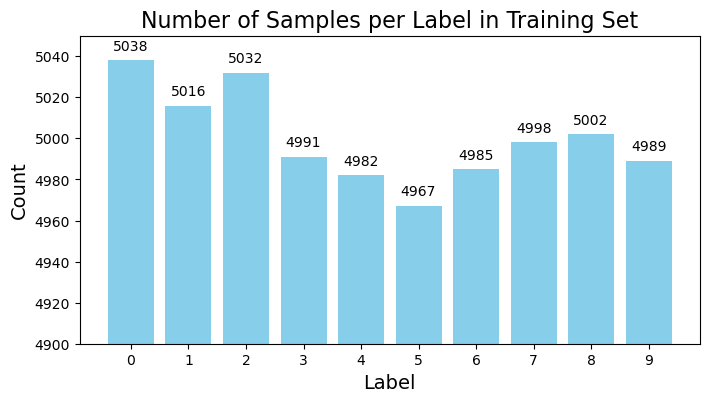

In [29]:
import matplotlib.pyplot as plt

unique_labels = np.unique(y_train)

plt.figure(figsize=(8, 4))
plt.bar(count_labels[0], count_labels[1], color='skyblue')
plt.title("Number of Samples per Label in Training Set", fontsize=16)
plt.xlabel("Label", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.ylim([4900, 5050])
plt.xticks(unique_labels)

for i, count in enumerate(count_labels[1]):
    plt.text(count_labels[0][i], count + 5, str(count), ha='center', fontsize=10)

plt.show()

In [30]:
print("Other Statistics for the training set:")
print(pd.Series(y_train).describe())

Other Statistics for the training set:
count    50000.00000
mean         4.49258
std          2.87539
min          0.00000
25%          2.00000
50%          4.00000
75%          7.00000
max          9.00000
dtype: float64


### Visualization_html

In [31]:
from IPython.core.display import HTML

# Count the labels
count_labels = np.unique(y_train, return_counts=True)

# Create DataFrame
label_counts_df = pd.DataFrame({
    "Label": count_labels[0],
    "Count": count_labels[1]
}).set_index("Label")

# Add a column for example images
def get_example_images(label, num_examples=10):
    indices = np.where(y_train == label)[0]
    selected_indices = np.random.choice(indices, size=min(num_examples, len(indices)), replace=False)
    example_images = [os.path.join(img_dir, data_train.iloc[i, 0]) for i in selected_indices]
    return " ".join([f'<img src="{img}" width="50" />' for img in example_images])

label_counts_df["Example Images"] = label_counts_df.index.map(get_example_images)

# Display the DataFrame with images
HTML(label_counts_df.to_html(escape=False))

,Count,Example Images
Label,,
0,5038,
1,5016,
2,5032,
3,4991,
4,4982,
5,4967,
6,4985,
7,4998,
8,5002,


### Visualization_plt

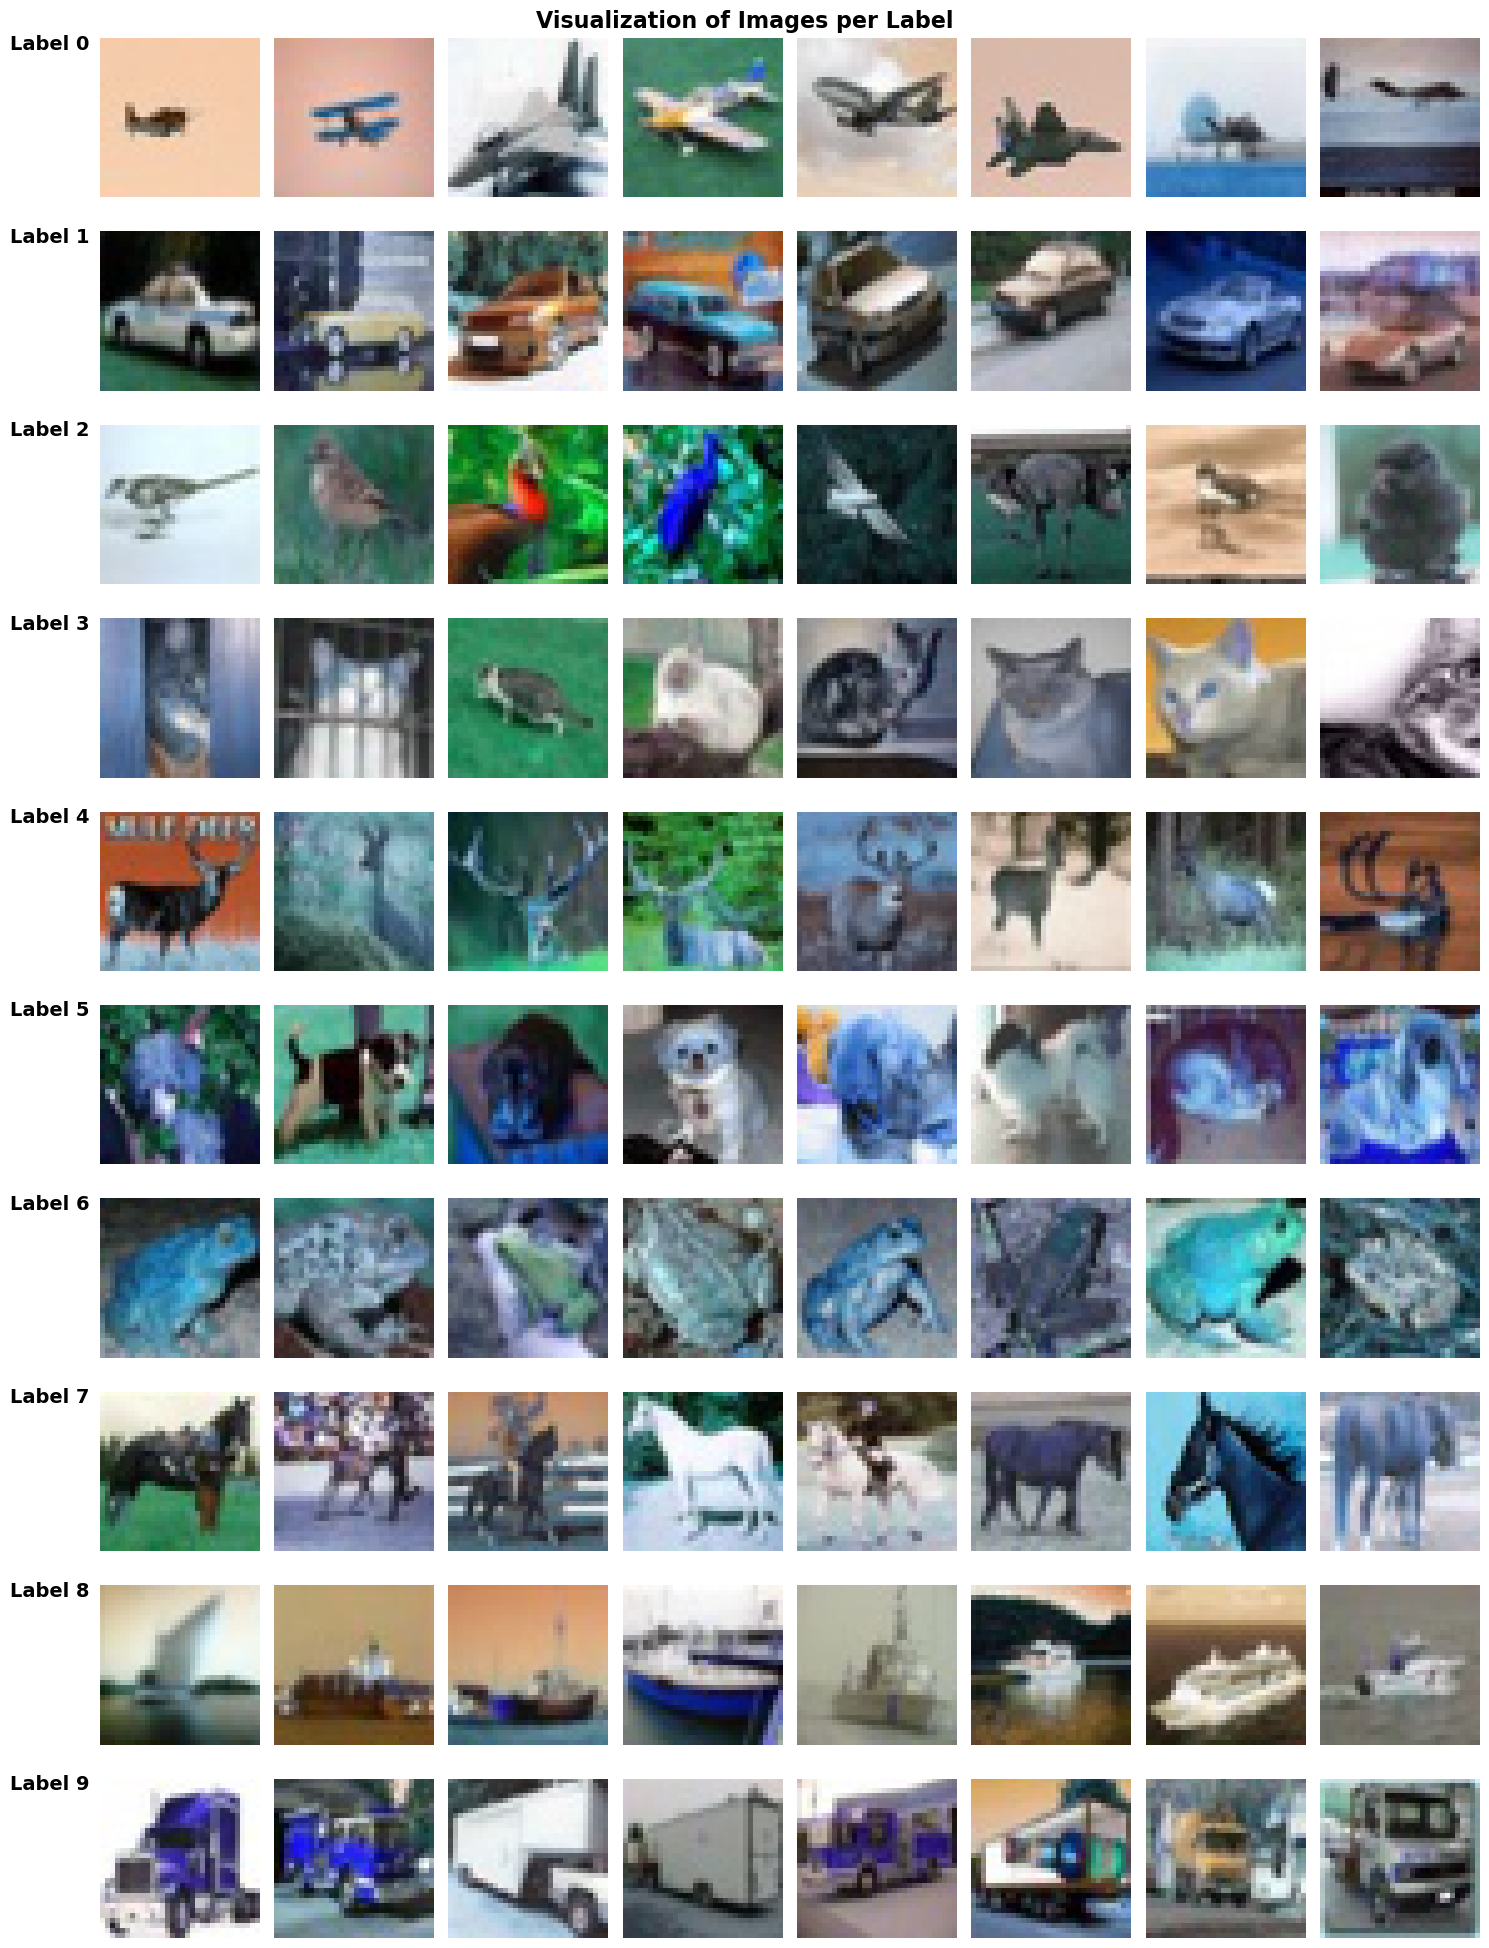

In [32]:
def visualize_images_by_label(img_dir, data, y, num_images=8):
    unique_labels = np.unique(y)  # Get all unique labels
    num_labels = len(unique_labels)  # Number of labels

    # Create a grid layout
    fig, axes = plt.subplots(num_labels, num_images, figsize=(15, num_labels * 2))
    fig.subplots_adjust(top=0.95)  # Adjust the top margin for the title
    fig.suptitle("Visualization of Images per Label", fontsize=16, fontweight='bold')  # Add title above the grid

    for i, label in enumerate(unique_labels):
        # Get indices corresponding to the current label
        indices = np.where(y == label)[0]
        # Randomly select num_images indices
        selected_indices = np.random.choice(indices, size=min(num_images, len(indices)), replace=False)

        for j, idx in enumerate(selected_indices):
            # Get the image path
            img_path = os.path.join(img_dir, data.iloc[idx, 0])
            # Open the image
            img = Image.open(img_path)

            # Display the image
            ax = axes[i, j] if num_labels > 1 else axes[j]  # Handle single-row case
            ax.imshow(img)
            ax.axis("off")  # Hide axes

        # Add label annotation to the first column of each row
        axes[i, 0].annotate(
            f"Label {label}",
            xy=(0, 0.5),
            xytext=(-axes[i, 0].yaxis.labelpad - 5, 0),
            textcoords="offset points",
            ha="right",
            va="center",
            fontsize=14,
            fontweight='bold',
            rotation=0,
        )

    plt.tight_layout()
    plt.show()

visualize_images_by_label(img_dir, data_train, y_train)



### Data Augmentation

In [33]:
import numpy as np
from PIL import Image, ImageEnhance
import random

# def random_crop(image, crop_size):
#     """
#     Randomly crop the image to the specified size.

#     Parameters:
#         image (PIL.Image): Input image.
#         crop_size (int): Size of the cropped image.

#     Returns:
#         PIL.Image: Cropped image.
#     """
#     width, height = image.size
#     left = random.randint(0, width - crop_size)
#     upper = random.randint(0, height - crop_size)
#     right = left + crop_size
#     lower = upper + crop_size
#     return image.crop((left, upper, right, lower))

# def random_rotation(image, max_angle=30):
#     """
#     Randomly rotate the image within a specified angle range.

#     Parameters:
#         image (PIL.Image): Input image.
#         max_angle (int): Maximum rotation angle in degrees.

#     Returns:
#         PIL.Image: Rotated image.
#     """
#     angle = random.randint(-max_angle, max_angle)
#     return image.rotate(angle)

# def color_jitter(image, brightness=0.2, contrast=0.2, color=0.2):
#     """
#     Apply random color jittering to the image.

#     Parameters:
#         image (PIL.Image): Input image.
#         brightness (float): Brightness adjustment factor range (e.g., 0.2 means [0.8, 1.2]).
#         contrast (float): Contrast adjustment factor range.
#         color (float): Color adjustment factor range.

#     Returns:
#         PIL.Image: Color-jittered image.
#     """
#     # Adjust brightness
#     enhancer = ImageEnhance.Brightness(image)
#     factor = random.uniform(1 - brightness, 1 + brightness)
#     image = enhancer.enhance(factor)

#     # Adjust contrast
#     enhancer = ImageEnhance.Contrast(image)
#     factor = random.uniform(1 - contrast, 1 + contrast)
#     image = enhancer.enhance(factor)

#     # Adjust color
#     enhancer = ImageEnhance.Color(image)
#     factor = random.uniform(1 - color, 1 + color)
#     image = enhancer.enhance(factor)

#     return image

# def aug_data(X, y, seed=None):
#     """
#     Augment the data by applying random cropping, random rotation, horizontal flipping, and color jittering.
#     """
#     if seed is not None:
#         random.seed(seed)
#         np.random.seed(seed)

#     X_aug = []
#     y_aug = []

#     for i in range(len(X)):
#         # Reshape to original image shape (H, W, C)
#         img = X[i].reshape(3, 32, 32).transpose(1, 2, 0)  # (32, 32, 3)
#         label = y[i]

#         # Convert to PIL Image for easier augmentation
#         pil_img = Image.fromarray(img)

#         # Append original image
#         X_aug.append(np.array(pil_img).flatten())
#         y_aug.append(label)

#         # Apply augmentations
#         # Horizontal flip
#         flipped_img = pil_img.transpose(Image.FLIP_LEFT_RIGHT)
#         X_aug.append(np.array(flipped_img).flatten())
#         y_aug.append(label)

#         # Random crop
#         if random.random() < 0.1:
#             crop_size = random.randint(24, 32)  # Random crop size between 24x24 and 32x32
#             cropped_img = random_crop(pil_img, crop_size).resize((32, 32))
#             X_aug.append(np.array(cropped_img).flatten())
#             y_aug.append(label)

#         # Random rotation
#         if random.random() < 0.1:
#             rotated_img = random_rotation(pil_img).resize((32, 32))
#             X_aug.append(np.array(rotated_img).flatten())
#             y_aug.append(label)

#         # Color jittering
#         if random.random() < 0.1:
#             jittered_img = color_jitter(pil_img)
#             X_aug.append(np.array(jittered_img).flatten())
#             y_aug.append(label)

#     return np.array(X_aug), np.array(y_aug)

# # Example usage
# X_train_aug, y_train_aug = aug_data(X_train, y_train, SEED)

### Data after augmentation

In [34]:
# print("Augmented training set shape: ", X_train_aug.shape)
# print("Augmented training set labels shape: ", y_train_aug.shape)
# # Count the labels
# count_labels = np.unique(y_train_aug, return_counts=True)
# # Create DataFrame
# label_counts_df = pd.DataFrame({
#     "Label": count_labels[0],
#     "Count": count_labels[1]
# }).set_index("Label")
# # Print DataFrame
# print("Count of each label in augmented training set:")
# print(label_counts_df)

### Resize

In [35]:
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
from tqdm import tqdm
import cv2

# def resize_images(images, target_size=(128, 128)):
#     """
#     Resize a list or array of images to the target size.

#     Parameters:
#         images (numpy.ndarray): Input images, shape (N, H, W, C) or (N, H*W*C).
#         target_size (tuple): Target size (width, height), default is (128, 128).

#     Returns:
#         numpy.ndarray: Resized images, shape (N, target_size[1], target_size[0], C).
#     """
#     resized_images = []
#     for img in images:
#         # If the image is flattened, reshape it to (H, W, C)
#         if len(img.shape) == 1:
#             img = img.reshape(32, 32, 3)  # Adjust this based on your original image shape

#         # Resize the image
#         resized_img = cv2.resize(img, target_size, interpolation=cv2.INTER_LINEAR)
#         resized_images.append(resized_img)

#     return np.array(resized_images)

# X_train_aug_resized = resize_images(X_train_aug, target_size=(128, 128))
# print("Resized images shape:", X_train_aug_resized.shape)

### Split the data

In [36]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=SEED)
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_val.shape)
print("Training labels shape:", y_train.shape)
print("Testing labels shape:", y_val.shape)

X_train = X_train.reshape(X_train.shape[0], -1)  # Flatten the images
X_val = X_val.reshape(X_val.shape[0], -1)  # Flatten the images
print("Flattened training set shape:", X_train.shape)
print("Flattened testing set shape:", X_val.shape)

Training set shape: (40000, 3072)
Testing set shape: (10000, 3072)
Training labels shape: (40000,)
Testing labels shape: (10000,)
Flattened training set shape: (40000, 3072)
Flattened testing set shape: (10000, 3072)


### Feature Extraction

### SIFT

In [37]:
import cv2
def SIFT_extractor(images):
    """
    Extract SIFT features from a list of images.

    Parameters:
        images (numpy.ndarray): Input images, shape (N, H, W, C).

    Returns:
        list: List of SIFT features for each image.
    """
    sift = cv2.SIFT_create()
    sift_features = []

    for img in tqdm(images, desc="Extracting SIFT features", total=len(images)):
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Detect keypoints and compute descriptors
        keypoints, descriptors = sift.detectAndCompute(gray, None)
        sift_features.append(descriptors)

    return sift_features

### HOG

In [ ]:
from skimage.feature import hog
def HOG_extractor(images, target_size=(128, 128)):
    """
    Extract HOG features from a list or array of images.

    Parameters:
        images (numpy.ndarray): Input images, shape (N, H, W, C) or (N, H*W*C).
        target_size (tuple): Target size to resize images before extracting HOG features.

    Returns:
        numpy.ndarray: HOG features for all images.
    """
    hog = cv2.HOGDescriptor()
    hog_features = []

    for img in tqdm(images, desc="Extracting HOG features", total=len(images)):
        if len(img.shape) == 1:
            img = img.reshape(32, 32, 3)

        # Resize the image to the target size
        resized_img = cv2.resize(img, target_size, interpolation=cv2.INTER_LINEAR)
        # Convert to grayscale (HOG works on single-channel images)
        gray_img = cv2.cvtColor(resized_img, cv2.COLOR_RGB2GRAY)
        # Compute HOG features
        hog_feature = hog.compute(gray_img)
        hog_features.append(hog_feature.flatten())

    return np.array(hog_features)

SyntaxError: invalid syntax (1505709403.py, line 1)

### EOG

In [ ]:
def EOG_extractor(images, target_size=(128, 128)):
    """
    Extract Edge Orientation Gradient (EOG) features from a list or array of images.

    Parameters:
        images (numpy.ndarray): Input images, shape (N, H, W, C) or (N, H*W*C).
        target_size (tuple): Target size to resize images before extracting EOG features.

    Returns:
        numpy.ndarray: EOG features for all images.
    """
    eog_features = []

    for img in tqdm(images, desc="Extracting EOG features", total=len(images)):
        if len(img.shape) == 1:
            img = img.reshape(32, 32, 3)

        # Resize the image to the target size
        resized_img = cv2.resize(img, target_size, interpolation=cv2.INTER_LINEAR)
        # Convert to grayscale
        gray_img = cv2.cvtColor(resized_img, cv2.COLOR_RGB2GRAY)
        # Apply Canny edge detection
        edges = cv2.Canny(gray_img, threshold1=100, threshold2=200)
        # Compute gradients in x and y directions
        grad_x = cv2.Sobel(edges, cv2.CV_64F, 1, 0, ksize=3)
        grad_y = cv2.Sobel(edges, cv2.CV_64F, 0, 1, ksize=3)
        # Compute gradient magnitude and orientation
        magnitude = np.sqrt(grad_x**2 + grad_y**2)
        orientation = np.arctan2(grad_y, grad_x)
        # Flatten the magnitude and orientation into a feature vector
        eog_feature = np.concatenate([magnitude.flatten(), orientation.flatten()])
        eog_features.append(eog_feature)

    return np.array(eog_features)

### LBP

In [ ]:
from skimage.feature import local_binary_pattern
from skimage.color import rgb2gray
from skimage.transform import resize

def LBP_extractor(images, target_size=(64, 64), P=8, R=1, method='uniform'):
    """
    Extract Local Binary Pattern (LBP) features from a list or array of images.

    Parameters:
        images (numpy.ndarray): Input images, shape (N, H, W, C) or (N, H*W*C).
        target_size (tuple): Target size to resize images before extracting LBP features.
        P (int): Number of circularly symmetric neighbor set points (quantization of the angular space).
        R (float): Radius of circle (spatial resolution of the operator).
        method (str): Method to determine the pattern ('default', 'ror', 'uniform', 'var').

    Returns:
        numpy.ndarray: LBP features for all images.
    """
    lbp_features = []

    for img in tqdm(images, desc="Extracting LBP features", total=len(images)):
        if len(img.shape) == 1:
            img = img.reshape(32, 32, 3)
        # Resize the image to the target size
        resized_img = resize(img, target_size, anti_aliasing=True)
        # Convert to grayscale
        gray_img = rgb2gray(resized_img)
        # Compute LBP
        lbp = local_binary_pattern(gray_img, P=P, R=R, method=method)
        # Flatten the LBP feature map into a 1D feature vector
        lbp_feature = lbp.flatten()
        lbp_features.append(lbp_feature)

    return np.array(lbp_features)

### ORB

In [ ]:
def ORB_extractor(images, target_size=(128, 128), n_features=500):
    """
    Extract ORB features from a list or array of images.

    Parameters:
        images (numpy.ndarray): Input images, shape (N, H, W, C) or (N, H*W*C).
        target_size (tuple): Target size to resize images before extracting ORB features.
        n_features (int): Maximum number of features to retain.

    Returns:
        numpy.ndarray: ORB descriptors for all images.
    """
    orb = cv2.ORB_create(nfeatures=n_features)
    orb_features = []

    for img in tqdm(images, desc="Extracting ORB features", total=len(images)):
        if len(img.shape) == 1:
            img = img.reshape(32, 32, 3)

        # Resize the image to the target size
        resized_img = cv2.resize(img, target_size, interpolation=cv2.INTER_LINEAR)
        # Convert to grayscale
        gray_img = cv2.cvtColor(resized_img, cv2.COLOR_RGB2GRAY)
        # Detect keypoints and compute descriptors
        keypoints, descriptors = orb.detectAndCompute(gray_img, None)
        # If no descriptors are found, append a zero vector
        if descriptors is None:
            descriptors = np.zeros((n_features, 32), dtype=np.uint8)
        # Flatten the descriptors and append to the list
        orb_features.append(descriptors.flatten())

    return np.array(orb_features)

### HIST

In [ ]:
def HIST_extractor(images, target_size=(128, 128), bins=(8, 8, 8)):
    """
    Extract color histogram (HIST) features from a list or array of images.

    Parameters:
        images (numpy.ndarray): Input images, shape (N, H, W, C) or (N, H*W*C).
        target_size (tuple): Target size to resize images before extracting HIST features.
        bins (tuple): Number of bins for each color channel (e.g., (8, 8, 8)).

    Returns:
        numpy.ndarray: HIST features for all images.
    """
    hist_features = []

    for img in tqdm(images, desc="Extracting HIST features", total=len(images)):
        # If the image is flattened, reshape it to (H, W, C)
        if len(img.shape) == 1:
            img = img.reshape(32, 32, 3)  # Adjust this based on your original image shape

        # Resize the image to the target size
        resized_img = cv2.resize(img, target_size, interpolation=cv2.INTER_LINEAR)
        # Compute the color histogram for each channel (B, G, R)
        hist = cv2.calcHist([resized_img], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
        # Normalize the histogram
        hist = cv2.normalize(hist, hist).flatten()
        # Append the histogram to the feature list
        hist_features.append(hist)
        

    return np.array(hist_features)

### Combine the features

In [ ]:
def combined_feature_extractor(images):
    """
    Extract combined features (HOG, EOG, LBP, ORB, HIST) from input images.

    Parameters:
        X (numpy.ndarray): Input images, shape (N, H, W, C) or (N, H*W*C).
        target_size (tuple): Target size to resize images before extracting features.
        n_features_orb (int): Maximum number of ORB features to retain.
        bins_hist (tuple): Number of bins for each color channel in HIST features.
        P_lbp (int): Number of circularly symmetric neighbor set points for LBP.
        R_lbp (float): Radius of circle for LBP.

    Returns:
        numpy.ndarray: Combined feature vectors for all images.
    """
    # Initialize lists to store features
    combined_features = []

    # Extract features
    sift_features = SIFT_extractor(images)
    hog_features = HOG_extractor(images)
    eog_features = EOG_extractor(images)
    lbp_features = LBP_extractor(images)
    orb_features = ORB_extractor(images)
    hist_features = HIST_extractor(images)
    # Combine features
    combined_features = np.concatenate((sift_features, hog_features, eog_features, lbp_features, orb_features, hist_features), axis=0)
    
    return combined_features
    
combined_features = combined_feature_extractor(X_train_aug_resized)
print("Combined features shape:", combined_features.shape)

### Convert training set with features

In [ ]:
X_train_featured = []
X_val_featured = []
for i in range(len(X_train)):
    X_train_featured.append(combined_features[i])
for i in range(len(X_val)):
    X_val_featured.append(combined_features[i])

X_train_featured = np.array(X_train_featured)
X_val_featured = np.array(X_val_featured)
print("X_train_featured shape:", X_train_featured.shape)
print("X_val_featured shape:", X_val_featured.shape)

### SVM + PCA

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

svm_model = make_pipeline(
    StandardScaler(), 
    PCA(n_components=0.75, random_state=SEED), 
    SVC(C=8, kernel='rbf', gamma='scale',random_state=SEED))

svm_model.fit(X_train_pca, y_train)

y_pred_svm = svm_model.predict(X_val_pca)
accuracy_svm = accuracy_score(y_val, y_pred_svm)
print(f"SVM Validation Accuracy: {accuracy_svm:.4f}")

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns
# Confusion Matrix
cm = confusion_matrix(y_val, y_pred_svm)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_val), yticklabels=np.unique(y_val)) 
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_val, y_pred_svm))

### Predict test data's class

In [ ]:
from PIL import Image

X_test_features = []
X_test_resized = resize_images(X_test)
for image in X_test_resized:
    combined_features = combine_feature(image)
    X_test_features.append(combined_features)
X_test_features = np.array(X_test_features)
print(f"Preprocessed test images shape: {X_test_features.shape}")

# Predict labels
y_test_pred = svm_clf.predict(X_test_features)

# Save predictions to CSV
test_df['label'] = y_test_pred
submission_file = './submission.csv'
test_df.to_csv(submission_file, index=False)

print(f"Predictions saved to {submission_file}")